In [ ]:
# the great wall of imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,precision_recall_curve,average_precision_score,accuracy_score,precision_score,recall_score,f1_score

import tensorflow as tf
from tensorflow.keras import layers,models,Input
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json,os,warnings

# Data Preprocessing

In [2]:
positives=np.load('synthetic/landslides_tensor_true_cleaned.npy') # 1501 positive samples sourced from NASA COOLR and USheffield GFLD
negatives=np.load('synthetic/landslides_tensor_false_cleaned.npy') # 2368 negative samples sourced by random spatiotemporal sampling

In [3]:
# initializing universal seed/random state for reproducibility
seed=42
np.random.seed(seed)
tf.random.set_seed(seed)

X=np.concatenate([positives,negatives],axis=0)
y=np.concatenate([np.ones(positives.shape[0]),np.zeros(negatives.shape[0])])

# minor data restructuring to separate static and dynamic channels (using a dual architecture conv3d)
# the first 6 channels are dynamic while the remaining 28 are static so i'll isolate
X_dynamic=X[:,:,:6,:,:]
X_static=X[:,0,6:,:,:]

In [4]:
# the datasets are originally extracted and exported in the shape (samples,time,width,height,channels)
# for the dynamic dataset we need channels to come last
# for the static dataset we also need channels last AND we can omit the temporal dimension
dynamic_transpose=(0,1,3,4,2)
static_transpose=(0,2,3,1)

# normalization scaling function
def normalize(Xdtrain,Xstrain,Xdval,Xsval,scaler=StandardScaler()):
    # dynamic channel normalization
    for ch in range(Xdtrain.shape[-1]):
        train_ch=Xdtrain[...,ch].reshape(-1,1)
        val_ch=Xdval[...,ch].reshape(-1,1)
        Xdtrain[...,ch]=scaler.fit_transform(train_ch).reshape(Xdtrain[...,ch].shape)
        Xdval[...,ch]=scaler.transform(val_ch).reshape(Xdval[...,ch].shape)

    # static channel normalization
    for ch in range(Xstrain.shape[-1]):
        train_ch=Xstrain[...,ch].reshape(-1,1)
        val_ch=Xsval[...,ch].reshape(-1,1)
        Xstrain[...,ch]=scaler.fit_transform(train_ch).reshape(Xstrain[...,ch].shape)
        Xsval[...,ch]=scaler.transform(val_ch).reshape(Xsval[...,ch].shape)

# define main training and validation datset for ensemble evaluation
indices=np.random.RandomState(seed).permutation(len(X_dynamic))
X_dynamic,X_static,y=X_dynamic[indices],X_static[indices],y[indices]

# shuffled train-validation split
train_idx,val_idx=train_test_split(range(len(y)),test_size=0.2,random_state=seed,stratify=y)
X_dynamic_train,X_dynamic_val=X_dynamic[train_idx],X_dynamic[val_idx]
X_static_train,X_static_val=X_static[train_idx],X_static[val_idx]
y_train,y_val=y[train_idx],y[val_idx]

# transpose for model input
X_dynamic_train=np.transpose(X_dynamic_train,dynamic_transpose)
X_dynamic_val=np.transpose(X_dynamic_val,dynamic_transpose)
X_static_train=np.transpose(X_static_train,static_transpose)
X_static_val=np.transpose(X_static_val,static_transpose)

normalize(X_dynamic_train,X_static_train,X_dynamic_val,X_static_val)

# Principal Components Analysis

In [5]:
# dynamic channel principal components analysis (PCA)
pca_dynamic=PCA()
pca_dynamic.fit(X_dynamic_train.reshape(-1,6)) # flatten 6 dynamic channels

# define threshold (min number of channels for retaining 95% variance), say N, then remove N most redundant channels
threshold_dynamic=np.argmax(np.cumsum(pca_dynamic.explained_variance_ratio_)>=0.95)+1
redundant_dynamic=np.argsort(np.abs(pca_dynamic.components_.T[:,:threshold_dynamic]).sum(axis=1))[:threshold_dynamic]

print(f'# of dynamic components for 95% variance: {threshold_dynamic}',f'most redundant channels: {redundant_dynamic}\n',sep='\n')

# static channel principal components analysis (PCA)
pca_static=PCA()
pca_static.fit(X_static_train.reshape(-1,28)) # flatten 28 static channels

# define threshold (min number of channels for retaining 95% variance), say N, then remove N most redundant channels
threshold_static=np.argmax(np.cumsum(pca_static.explained_variance_ratio_)>=0.95)+1
redundant_static=np.argsort(np.abs(pca_static.components_.T[:,:threshold_static]).sum(axis=1))[:threshold_static]

print(f'# of static components for 95% variance: {threshold_static}',f'most redundant channels: {redundant_static}',sep='\n')

# of dynamic components for 95% variance: 3
most redundant channels: [3 4 5]

# of static components for 95% variance: 15
most redundant channels: [13  0  6  7 26 25 21 24 23 22 14 20  4  1 19]


In [6]:
# remove redundant channels from dynamic data
keep_dynamic=np.setdiff1d(np.arange(6),redundant_dynamic)
X_dynamic_train=X_dynamic_train[:,:,:,:,keep_dynamic]
X_dynamic_val=X_dynamic_val[:,:,:,:,keep_dynamic]

# remove redundant channels from static data
keep_static=np.setdiff1d(np.arange(28),redundant_static)
X_static_train=X_static_train[:,:,:,keep_static]
X_static_val=X_static_val[:,:,:,keep_static]

# define shape tuples
dynamic_shape=(12,15,15,len(keep_dynamic))
static_shape=(15,15,len(keep_static))

print(f'dynamic channels kept: {keep_dynamic}',f'static channels kept: {keep_static}',sep='\n')

dynamic channels kept: [0 1 2]
static channels kept: [ 2  3  5  8  9 10 11 12 15 16 17 18 27]


# Model Architecture & Training

In [7]:
# temporally focused conv3d (temp. focused because of large temporal kernels) w/ dual architecture
def create_temporal_conv3d(dynamic_shape=dynamic_shape, static_shape=static_shape):
    # dynamic branch
    dynamic_input=Input(shape=dynamic_shape,name='dynamic_input')

    # larger temporal kernel (5 steps) + small spatial (3x3), 8 filters
    x1=layers.Conv3D(8,(5,3,3),padding='same',activation='relu')(dynamic_input)
    x1=layers.GlobalAveragePooling3D()(x1) # aggressive avg pooling
    
    # static branch, only spatial features & pols directly, 8 filters
    static_input=Input(shape=static_shape,name='static_input')
    x2=layers.Conv2D(8,(3,3),padding='same',activation='relu')(static_input)
    x2=layers.GlobalAveragePooling2D()(x2) # aggressive avg pooling
    
    # merge branches (24 filters from each means 48 total features)
    # synthesize both weather patterns and terrain vulnerability
    merged=layers.concatenate([x1,x2])

    # dense layers + 50% dropout to minimize overfitting
    x=layers.Dense(16,activation='relu')(merged)
    x=layers.Dropout(0.5)(x)

    # final output layer mapped through a sigmoid activation for 0-1 landslide risk value
    output=layers.Dense(1,activation='sigmoid')(x)
    
    # compile model, output
    model=models.Model(inputs=[dynamic_input,static_input],outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    return model

In [8]:
def train_single_model(model=create_temporal_conv3d()):

    # split data
    indices=np.arange(len(X_dynamic))
    train_idx,val_idx=train_test_split(indices,test_size=0.2,random_state=seed,stratify=y)
    
    # separate arrays into train/validation split
    X_dynamic_train=X_dynamic[train_idx][:,:,keep_dynamic,:,:]
    X_dynamic_val=X_dynamic[val_idx][:,:,keep_dynamic,:,:]
    X_static_train=X_static[train_idx][:,keep_static,:,:]
    X_static_val=X_static[val_idx][:,keep_static,:,:]
    y_train=y[train_idx]
    y_val=y[val_idx]
    
    # transpose arrays, normalize for model intake
    X_dynamic_train=np.transpose(X_dynamic_train,dynamic_transpose)
    X_dynamic_val=np.transpose(X_dynamic_val,dynamic_transpose)
    X_static_train=np.transpose(X_static_train,static_transpose)
    X_static_val=np.transpose(X_static_val,static_transpose)
    normalize(X_dynamic_train,X_static_train,X_dynamic_val,X_static_val)
    
    # class weights to correct dataset class imbalance
    class_weights=compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
    class_weight_dict={0:class_weights[0],1:class_weights[1]}
    
    # define training callbacks
    callbacks=[
        EarlyStopping(monitor='val_auc',patience=20,restore_best_weights=True,mode='max',verbose=1),
        ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10,min_lr=1e-6,verbose=1)]

    # fit model
    history=model.fit(
        [X_dynamic_train,X_static_train],
        y_train,
        validation_data=([X_dynamic_val,X_static_val],y_val),
        epochs=150,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1)
    
    return model,history

In [9]:
def save_model(model,seed,save_dir='intwari_model'):

    # create directory, save model
    os.makedirs(save_dir,exist_ok=True)
    model.save(f'{save_dir}/model.keras')
    
    # save relevant metadata information
    metadata={
        'model_type':'temporal_conv3d',
        'random_seed':seed,
        'dynamic_shape':dynamic_shape,
        'static_shape':static_shape,
        'framework_version':tf.__version__}
    with open(f'{save_dir}/model_info.json','w') as f:
        json.dump(metadata,f,indent=2)

In [10]:
class LandslideModel:
    def __init__(self,model_dir='intwari_model'):
        # load metadata + individual model
        self.model_dir=model_dir
        with open(f'{model_dir}/model_info.json','r') as f:
            self.info=json.load(f)
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore',category=UserWarning)
            self.model=load_model(f'{model_dir}/model.keras',compile=False)

            # manual recompiling
            self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    
    # make a singular prediction
    def predict(self,X_dynamic,X_static):
        return self.model.predict([X_dynamic,X_static],verbose=0).flatten()
    
    # split sample into dynamic and static splits
    def branch(self,X):
        return X[:,:,:threshold_dynamic,:,:],X[:,0,threshold_dynamic:,:,:]

    # preprocessing thing for singular sample input
    # if you see this i forgot to delete this thing
    def preprocess(self,arr):
        return np.transpose(arr[:,keep_dynamic,:,:][np.newaxis,...],dynamic_transpose),np.transpose(arr[0,keep_static+6,:,:][np.newaxis,...],static_transpose)

# load the ensemble
Atlas=LandslideModel()
predictions=Atlas.predict(X_dynamic_val,X_static_val)

# risk score range and other info
print(f'risk scores info:',f'median: {np.median(predictions):.3f}',f'mean: {predictions.mean():.3f}',f'range: [{predictions.min():.3f},{predictions.max():.3f}]',f'stdev: {predictions.std():.3f}',sep='\n')

risk scores info:
median: 0.477
mean: 0.446
range: [0.015,0.903]
stdev: 0.218


# Evalutation

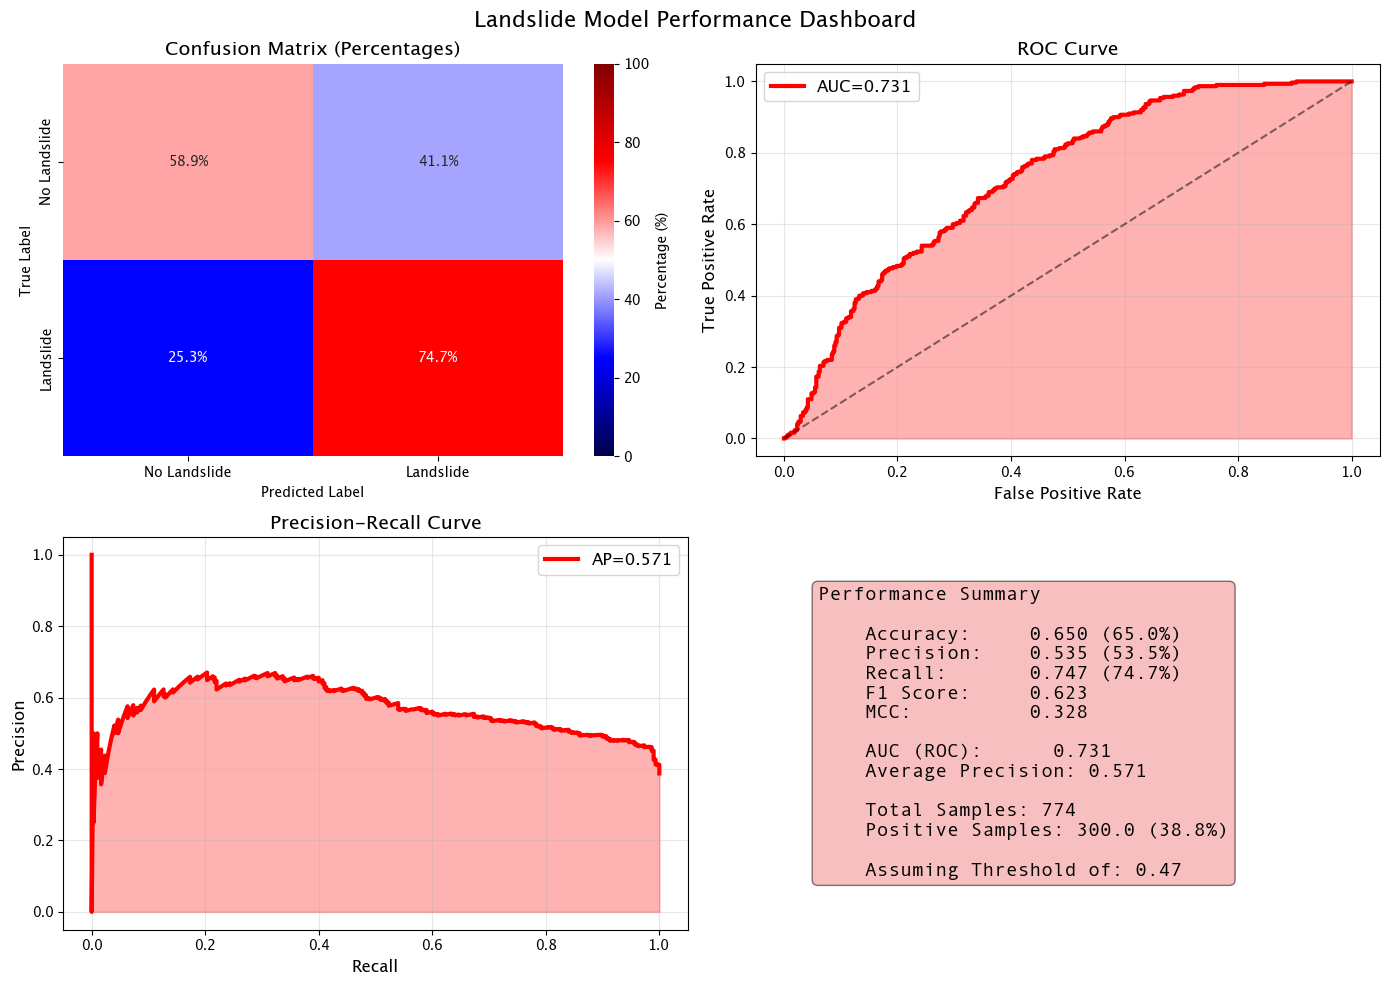

In [11]:
# comprehensive model evaluation
def plot_model_performance(y_true,y_pred_proba,threshold=0.5):
    
    # convert probabilities to predictions
    y_pred=(y_pred_proba>threshold).astype(int).flatten()
    
    # create figure
    fig=plt.figure(figsize=(14,10))
    
    # 1) confusion matrix
    plt.subplot(2,2,1)
    cm=confusion_matrix(y_true,y_pred)
    cm_percent=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]*100
    sns.heatmap(cm_percent,annot=True,fmt='.1f',cmap='seismic',xticklabels=['No Landslide','Landslide'],yticklabels=['No Landslide','Landslide'],cbar_kws={'label': 'Percentage (%)'},vmin=0,vmax=100)
    for t in plt.gca().texts:t.set_text(t.get_text()+'%')
    plt.title('Confusion Matrix (Percentages)',fontsize=14)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 2) roc curve for auc
    plt.subplot(2,2,2)
    fpr,tpr,_=roc_curve(y_true,y_pred_proba)
    auc=roc_auc_score(y_true,y_pred_proba)
    plt.plot(fpr,tpr,'r-',linewidth=3,label=f'AUC={auc:.3f}')
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.fill_between(fpr,tpr,alpha=0.3,color='red')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('ROC Curve',fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True,alpha=0.3)
    
    # 3) precision recall curve
    plt.subplot(2,2,3)
    precision,recall,_=precision_recall_curve(y_true,y_pred_proba)
    ap=average_precision_score(y_true,y_pred_proba)
    plt.plot(recall,precision,'r-',linewidth=3,label=f'AP={ap:.3f}')
    plt.fill_between(recall,precision,alpha=0.3,color='red')
    plt.xlabel('Recall',fontsize=12)
    plt.ylabel('Precision',fontsize=12)
    plt.title('Precision-Recall Curve',fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True,alpha=0.3)
    
    # 4) performance metrics summary
    plt.subplot(2,2,4)
    plt.axis('off')
    acc=accuracy_score(y_true,y_pred)
    prec=precision_score(y_true,y_pred)
    rec=recall_score(y_true,y_pred)
    f1=f1_score(y_true,y_pred)
    tn,fp,fn,tp=cm.ravel()
    mcc=((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn + fn))
    metrics_text=f"""Performance Summary\n
    Accuracy:     {acc:.3f} ({acc*100:.1f}%)
    Precision:    {prec:.3f} ({prec*100:.1f}%)
    Recall:       {rec:.3f} ({rec*100:.1f}%)
    F1 Score:     {f1:.3f}
    MCC:          {mcc:.3f}\n
    AUC (ROC):      {auc:.3f}
    Average Precision: {ap:.3f}\n
    Total Samples: {len(y_true)}
    Positive Samples: {sum(y_true)} ({sum(y_true)/len(y_true)*100:.1f}%)\n
    Assuming Threshold of: {threshold}"""
    plt.text(0.1,0.5,metrics_text,fontsize=14,family='monospace',verticalalignment='center',bbox=dict(boxstyle='round',facecolor='lightcoral',alpha=0.5))
    plt.suptitle('Landslide Model Performance Dashboard',fontsize=16,fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_model_performance(y_val,Atlas.predict(X_dynamic_val,X_static_val),threshold=0.47)

# Theoretical Maximum Metrics with Temporal Label Noise

The training dataset (specifically the positive events) consists of a filtered and merged collection of points from the NASA COOLR dataset (324) and the University of Sheffield's GFLD dataset (1177). The GFLD assigns only dates to landslide events whereas COOLR assigns exact times. This model works with intervals of 6 hours. In the data preprocessing step, I randomly assigned each of the GFLD events to one of four time intervals (4 intervals of 6 hours constitute one day, meaning approximately 3 out of every 4 GFLD points was incorrectly assigned a time) which means that my dataset does have a considerable degree of positive noise. Thus, even a theoretically perfect classifier could return some false negatives. Therefore, part of the error in any model trained and validated off of this dataset can be attributed to training noise as opposed to model inaccuracy. This error can be quantified as demonstrated:

## Definitions

Let:
- $T$ be the set of positive elements
- $F$ be the set of negative elements  
- $R$ be the ratio of positive elements with randomly assigned time values, where $R \in [\frac{1177}{1501},1]$
- $N$ be the set of all elements, $N = T \cup F$

## Label Distribution

- roughly $(1-R)|T|$ elements will have correctly assigned times
- roughly $R|T|$ elements will have randomly assigned times

Of the $R|T|$ elements with randomly assigned times:
- roughly $\frac{1}{4}R|T|$ will be correctly assigned at random
- roughly $\frac{3}{4}R|T|$ will be incorrectly assigned at random

## Confusion Matrix for a Perfect Classifier

For a theoretically perfect classifier:

$$\text{TP} = (1-R)|T| + \frac{1}{4}R|T| = |T|\left(1-\frac{3R}{4}\right)$$

$$\text{FN} = \frac{3}{4}R|T|$$

$$\text{TN} = |F|$$

$$\text{FP} = \emptyset$$

## Derived Rates

$$\text{TPR} = \frac{\text{TP}}{\text{TP}+\text{FN}} = \frac{\text{TP}}{|T|} = \frac{|T|(1-\frac{3R}{4})}{|T|} = 1-\frac{3R}{4}$$

$$\text{FPR} = \frac{\text{FP}}{\text{FP}+\text{TN}} = \frac{|\emptyset|}{|F|} = 0$$

$$\text{TNR} = \frac{\text{TN}}{\text{TN}+\text{FP}} = \frac{|F|}{|F|} = 1$$

$$\text{FNR} = \frac{\text{FN}}{\text{TP}+\text{FN}} = \frac{\frac{3}{4}R|T|}{|T|} = \frac{3R}{4}$$

## Theoretical Maximum Model Performance Metrics

### Accuracy:
$$\text{Accuracy} = \frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}} \approx \frac{|T|\left(1-\frac{3R}{4}\right) + |F|}{|N|}$$

### Precision:
$$\text{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}} = \frac{\text{TP}}{\text{TP}} = 1$$

### Recall:
$$\text{Recall} = \frac{\text{TP}}{\text{TP}+\text{FN}} \approx \frac{|T|\left(1-\frac{3R}{4}\right)}{|T|} = \text{TPR} = 1-\frac{3R}{4}$$

### F1 Score (harmonic mean of Precision & Recall):
$$\text{F1} = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} \approx \frac{2 - \frac{3R}{2}}{2 - \frac{3R}{4}} = \frac{8-6R}{8-3R}$$

### AUC-ROC:
$$\text{AUC-ROC} = \int \text{TPR}(\text{FPR}) \, d\text{FPR}$$

Since the ROC curve consists of:
1. Vertical segment from $(0, 0)$ to $(0, \text{TPR})$
2. Horizontal segment from $(0, \text{TPR})$ to $(1, \text{TPR})$  
3. Vertical segment from $(1, \text{TPR})$ to $(1, 1)$

$$\text{AUC-ROC} = \text{TPR} + \frac{1-\text{TPR}}{2} = \frac{1+\text{TPR}}{2} \approx 1 - \frac{3R}{8}$$